# LLC4320 data access demonstration using `xarray`

Miguel Jimenez-Urias May '25


### The environment requires:

```python

pip install --upgrade fsspec
pip install --upgrade xarray
pip install --upgrade dask
pip install --upgrade distributed

```


In [1]:
import fsspec
import xarray as xr
from dask.distributed import Client

# for benchmarking using dask
import dask
from dask import delayed, compute
from dask.distributed import Client
import gc

In [2]:
print("fsspec version: ", fsspec.__version__)
print("xarray: ", xr.__version__)
print("dask version: ", dask.__version__)

fsspec version:  2025.3.2
xarray:  2024.7.0
dask version:  2024.8.0


In [3]:
client = Client(n_workers=4, threads_per_worker=2)  # Basic limited cpu example
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45929,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:35107,Total threads: 2
Dashboard: http://127.0.0.1:37943/status,Memory: 59.60 GiB
Nanny: tcp://127.0.0.1:38593,


# Json Kerchunk references

Each LLC4320 field variable has a Kerchunk reference to speed up metadata creation that points to all the associated distributed zarr stores across the ceph cluster.

In [4]:
ceph_path = "/home/idies/workspace/poseidon_ceph/LLC4320/"
Ker_path = ceph_path + "Kerchunks/"

# Individual 4D variables:
Salt_json= Ker_path + "LLC4320_SALT.json"
Theta_json = Ker_path + "LLC4320_THETA.json"
U_json =  Ker_path + "LLC4320_U.json"
V_json =  Ker_path+ "LLC4320_V.json"
W_json =   Ker_path + "LLC4320_W.json"

# Individual 3D (surface) variables:
Eta_json = Ker_path + "LLC4320_Eta.json"
KPPhbl_json = Ker_path + "LLC4320_KPPhbl.json"
PhiBot_json =  Ker_path + "LLC4320_PhiBot.json"
SIarea_json =  Ker_path + "LLC4320_SIarea.json"
SIheff_json =  Ker_path + "LLC4320_SIheff.json"
SIhsalt_json =  Ker_path + "LLC4320_SIhsalt.json"
SIhsnow_json =  Ker_path + "LLC4320_SIhsnow.json"
SIuice_json =  Ker_path + "LLC4320_SIuice.json"
SIvice_json =  Ker_path + "LLC4320_SIvice.json"
oceFWflx_json =  Ker_path + "LLC4320_oceFWflx.json"
oceQnet_json =  Ker_path + "LLC4320_oceQnet.json"
oceQsw_json =  Ker_path + "LLC4320_oceQsw.json"
oceSflux_json =  Ker_path + "LLC4320_oceSflux.json"
oceTAUX_json =  Ker_path + "LLC4320_oceTAUX.json"
oceTAUY_json =  Ker_path + "LLC4320_oceTAUY.json"

# All 3D (surface) variables:
Surface_json = "LLC4320_Surface.json" # get all surface variables at once

# Open the zarr stores

### Identify all variables you can in your dataset by including the json path of its Kerchunk references 

```python
json_paths=[Kerchunk_json1, Kerchunk_json2,...]
```



In [5]:
# Here, add the json files of the variables you want to include in your dataset
json_paths = [Salt_json, Theta_json, U_json, V_json, W_json, Eta_json, KPPhbl_json, 
              PhiBot_json,  SIarea_json, SIheff_json, SIhsalt_json, SIhsnow_json, 
              SIuice_json, SIvice_json, oceFWflx_json, oceQnet_json, oceQsw_json,
              oceSflux_json, oceTAUX_json, oceTAUY_json,
             ]

# Load the LLC4320 grid


In [6]:
grid_path = ceph_path
ds_grid = xr.open_zarr(grid_path)
ds_grid = ds_grid.set_coords([var for var in ds_grid.data_vars])
ds_grid

<xarray.Dataset> Size: 346GB
Dimensions:  (face: 13, j: 4320, i: 4320, k: 90, k_p1: 91, j_g: 4320,
              i_g: 4320, k_l: 90, k_u: 90)
Coordinates: (12/43)
    CS       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    Depth    (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    PHrefC   (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    XC       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    ...       ...
    mask_w   (k, face, j, i_g) bool 22GB dask.array<chunksize=(90, 1, 720, 720), meta=np.ndarray>
    rA       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAs      (face, j_g, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAw      (face, j, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rhoRef   (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
Data variables:
    *empty*

# Create xarray datasets

There is no significant performance gain when using dask for parallel read/creation of the mapper object. The code runs sequentially (unfortunately). But it provides a clean
way to create the xarray dataset in a few lines, avoiding repeated code.

In [7]:
@delayed
def delayed_open_mapper(json_file):
    fs = fsspec.filesystem("reference", fo=json_file)
    mapper = fs.get_mapper("")
    return mapper

def open_mapper(json_file):
    fs = fsspec.filesystem("reference", fo=json_file)
    mapper = fs.get_mapper("")
    return mapper

In [8]:
%%time
# instantly runs
# delayed_mappers = [delayed_open_mapper(json_path) for json_path in json_paths]

# ===========
# This may take almost as much as running sequentially
# It takes ~ 10*N secs, with N the number of variables
# ===========

# Distribute JSON paths to workers first
scattered_paths = client.scatter(json_paths, broadcast=False)
# Then submit open_mapper to each
futures = [client.submit(open_mapper, path) for path in scattered_paths]

# Optionally wait for all to complete
mappers = client.gather(futures)  # This doesn't move data, just ensures completion

# mappers = [open_mapper(path) for path in json_paths]

CPU times: user 2min 49s, sys: 15.1 s, total: 3min 4s
Wall time: 3min 46s


## Dataset creation

In [9]:
%%time
ds = xr.merge([xr.open_zarr(mapper, consolidated=False) for mapper in mappers]+[ds_grid])
ds

CPU times: user 1min 16s, sys: 1.89 s, total: 1min 18s
Wall time: 1min 17s


<xarray.Dataset> Size: 5PB
Dimensions:   (time: 10311, k: 90, face: 13, j: 4320, i: 4320, i_g: 4320,
               j_g: 4320, k_l: 90, k_p1: 91, k_u: 90)
Coordinates: (12/44)
  * face      (face) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i         (i) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j         (j) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * k         (k) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * time      (time) datetime64[ns] 82kB 2011-09-13 ... 2012-11-15T14:00:00
  * i_g       (i_g) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    ...        ...
    mask_w    (k, face, j, i_g) bool 22GB dask.array<chunksize=(90, 1, 720, 720), meta=np.ndarray>
    rA        (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAs       (face, j_g, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAw       (face, j, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAz       (face, j_g, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rhoRef    (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
Data variables: (12/20)
    Salt      (time, k, face, j, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    Theta     (time, k, face, j, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    U         (time, k, face, j, i_g) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    V         (time, k, face, j_g, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    W         (time, k_l, face, j, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    Eta       (time, face, j, i) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>
    ...        ...
    oceFWflx  (time, face, j, i) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>
    oceQnet   (time, face, j, i) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>
    oceQsw    (time, face, j, i) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>
    oceSflux  (time, face, j, i) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>
    oceTAUX   (time, face, j, i_g) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>
    oceTAUY   (time, face, j_g, i) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>

In [10]:
print("Size of dataset (uncompressed) : ", ds.nbytes/1e15, "Petabytes")

Size of dataset (uncompressed) :  4.653255158550172 Petabytes


## Some plotting examples

The following approach of closing the client before plotting is much faster (see end of notebook).


In [11]:
# client.close()

CPU times: user 11.1 s, sys: 1.01 s, total: 12.1 s
Wall time: 24.5 s


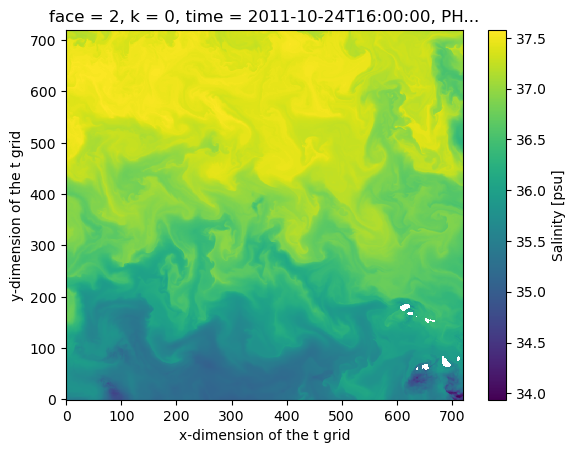

In [12]:
%%time
ds['Salt'].isel(time=1000, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot();

CPU times: user 10.8 s, sys: 998 ms, total: 11.8 s
Wall time: 21.5 s


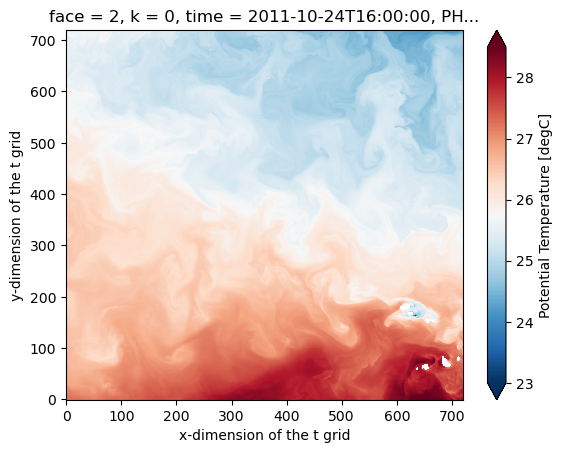

In [13]:
%%time
ds['Theta'].isel(time=1000, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);

CPU times: user 11 s, sys: 942 ms, total: 11.9 s
Wall time: 23 s


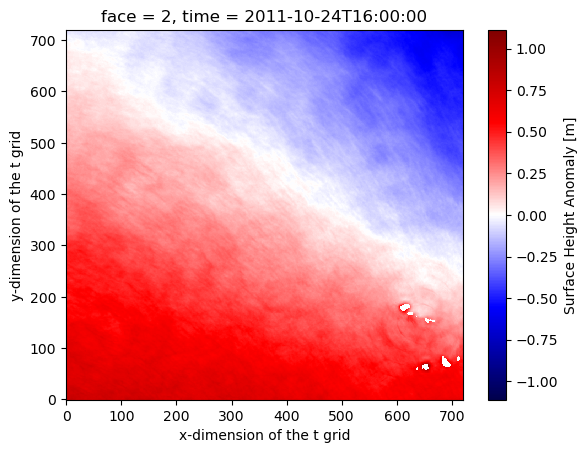

In [14]:
%%time
ds['Eta'].isel(time=1000,face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='seismic');

# Load all LLC4320 surface variables

A json kerchunk file is available to open all surface variables at once. 

You can use this to create a dataset for all surface variables at once (I do not see any performance gain doing this)


```python

%%time
mapper_surface = open_mapper(Surface_json)
ds_theta = xr.open_zarr(mapper_surface, consolidated=False)
```



# Timing of plots

With, and without initializing the Client object. I am finding $4\times$ slower performance to plot a chunk of data, when initializing client, vs non-initalizing the client.


I will look only at Theta


In [15]:
%%time
mapper_surface = open_mapper(Theta_json)
ds_theta = xr.open_zarr(mapper_surface, consolidated=False)

CPU times: user 9.4 s, sys: 809 ms, total: 10.2 s
Wall time: 10.2 s


CPU times: user 26.1 s, sys: 4.31 s, total: 30.4 s
Wall time: 40 s


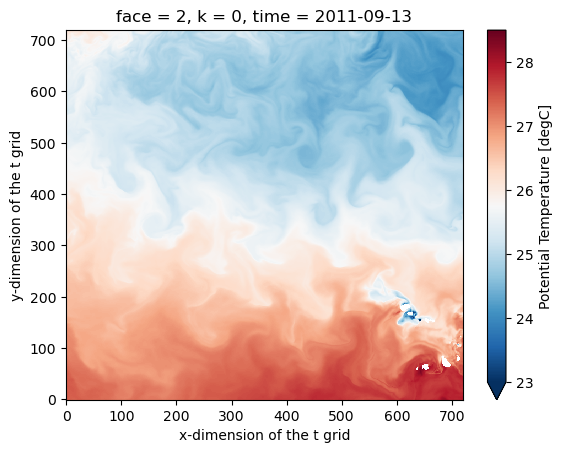

In [16]:
%%time
ds_theta['Theta'].isel(time=0, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);

In [17]:
client = Client()
client

/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40089 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40089/status,
Dashboard: http://127.0.0.1:40089/status,Workers: 16
Total threads: 128,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34787,Workers: 16
Dashboard: http://127.0.0.1:40089/status,Total threads: 128
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:45625,Total threads: 8
Dashboard: http://127.0.0.1:36379/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:41039,


CPU times: user 11.5 s, sys: 1.21 s, total: 12.7 s
Wall time: 21.2 s


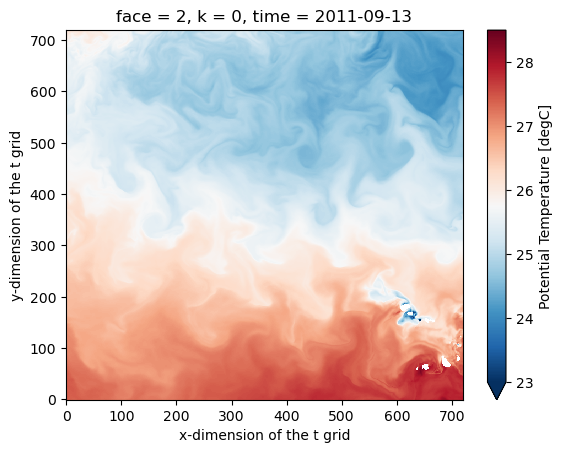

In [18]:
%%time
ds_theta['Theta'].isel(time=0, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);

In [19]:
client.close()

CPU times: user 10.8 s, sys: 944 ms, total: 11.7 s
Wall time: 17.9 s


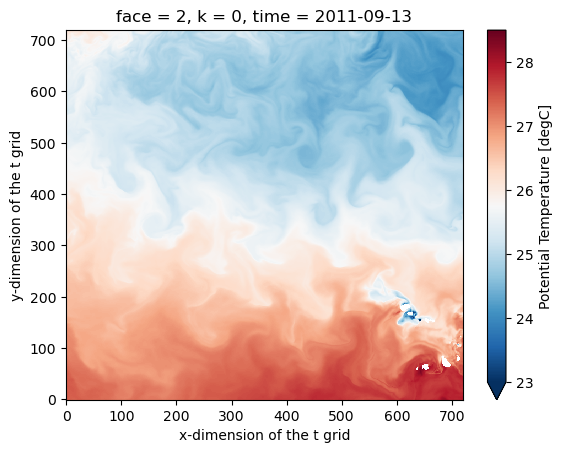

In [20]:
%%time
ds_theta['Theta'].isel(time=0, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);

CPU times: user 10.8 s, sys: 1.02 s, total: 11.8 s
Wall time: 21.6 s


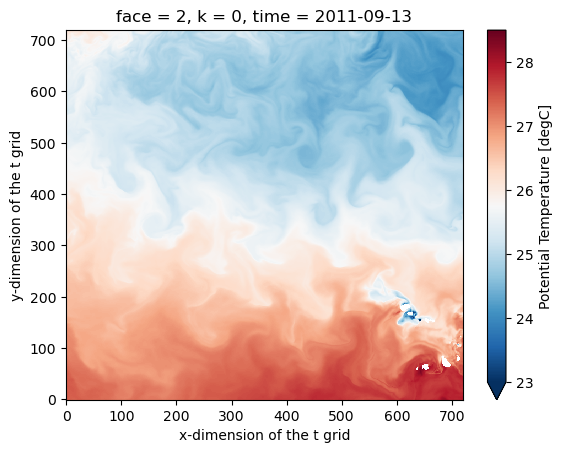

In [21]:
%%time
ds_theta['Theta'].isel(time=0, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);

In [22]:
client = Client()
client

/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38715 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38715/status,
Dashboard: http://127.0.0.1:38715/status,Workers: 16
Total threads: 128,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37135,Workers: 16
Dashboard: http://127.0.0.1:38715/status,Total threads: 128
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:35723,Total threads: 8
Dashboard: http://127.0.0.1:46425/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:41847,


CPU times: user 11.3 s, sys: 1.21 s, total: 12.5 s
Wall time: 20.8 s


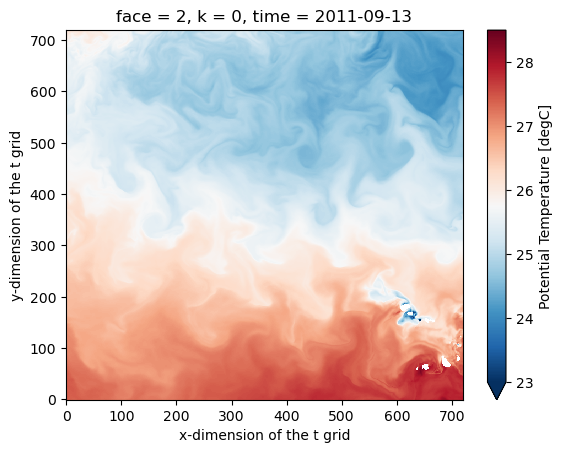

In [23]:
%%time
ds_theta['Theta'].isel(time=0, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);

CPU times: user 11.6 s, sys: 1.2 s, total: 12.8 s
Wall time: 21.5 s


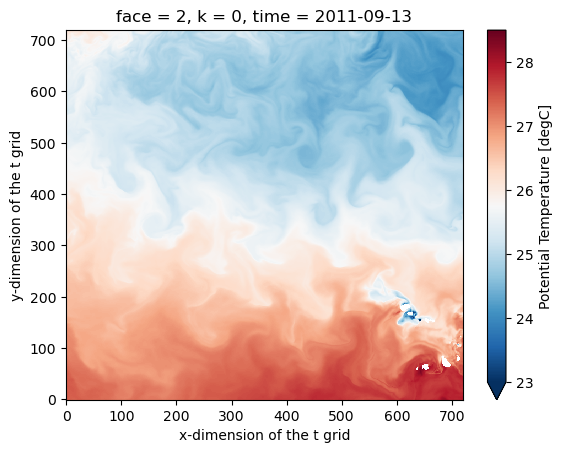

In [24]:
%%time
ds_theta['Theta'].isel(time=0, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);